#                                                Four Node Grid Stability


**Associated Tasks:** Regression

## What is a Smart Grid?

**A Smart Grid** is an electrical grid that includes a variety of operating and energy metrics, including smart meters, smart devices, renewable energy resources, and energy efficient resources.
The important aspect of a smart grid are the electronic power conditioning and control of the production and distribution of electricity.

### The feature of the smart grid 

The feature of the smart grid are:

1. Reliability
2. Flexibility in network topology
3. Efficiency 
4. Sustainability
5. Market-enabling


<center>
    <img  width="750"  src="https://upload.wikimedia.org/wikipedia/commons/8/84/Staying_big_or_getting_smaller.jpg">
</center>
<center> Characteristics of a smart grid (right) versus the traditional system (left). Wikipedia </center>


Smart grid concept suggest to collect consumer demand data, centrally evaluate them given current supply and send price information back to customer for them to decide about usage. Due to the restrictions regarding IT information such that Cyber security, privacy protection and large required investments it remains unclear how such central can guarantee overall stability.




<a id="introduction"></a>
### Introduction
​
Share of renewable electricity production in Germany has grown from 9% in 2002 to 46% in 2019, an important progress for meeting climate targets. However, intermittency of weather-dependent renewable sources makes it harder and more expensive to maintain grid stability (a balance of electricity production and consumption). The Decentral Smart Grid Control (DSGC) concept was proposed as a way to adjust price based on supply and demand in a decentralised way - giving consumers an incentive to adjust their usage and help stabilise the grid without needing to centrally collect their usage data.
​
The data set I'm using was originally simulated to explore if grid stability can be maintained under DSGC, assuming a 4-node architecture: one producer providing electricity to three consumers. There are 10,000 instances and 12 attributes:  
- `p[x]` (`p1` to `p4`): power produced or consumed; `p1 = abs(p2 + p3 + p4)`
- `g[x]` (`g1` to `g4`): willingness of each node to adapt their consumption or production per second (gamma, proportional to price elasticity)  
- `tau[x]` (`tau1` to `tau4`): how long it takes for each node to adapt their production or consumption in seconds
​
where `p1`, `g1` and `tau1` are related to the electricity producer; the rest are related to the electricity consumers.
​
There are also two target variables:  
- `stab`: a number representing grid stability (positive if unstable)
- `stabf`: a categorical version of `stab`

## Preprocessing and Plotting Libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, RocCurveDisplay,confusion_matrix
from sklearn.metrics import plot_roc_curve, roc_auc_score, classification_report, accuracy_score, f1_score
from sklearn.metrics import recall_score, plot_confusion_matrix, precision_score, plot_precision_recall_curve, classification_report
from sklearn.metrics import confusion_matrix    #Evaluation of model results

In [2]:
df=pd.read_csv("Smart_grid_dataset.csv") # importing the data set from my local disk

In [3]:
df.tail()

,tau1,tau2,tau3,tau4,p1,p2,p3,p4,g1,g2,g3,g4,stab,stabf
9995,2.930406,9.487627,2.376523,6.187797,3.343416,-0.658054,-1.449106,-1.236256,0.601709,0.779642,0.813512,0.608385,0.023892,unstable
9996,3.392299,1.274827,2.954947,6.894759,4.349512,-1.663661,-0.952437,-1.733414,0.502079,0.567242,0.285880,0.366120,-0.025803,stable
9997,2.364034,2.842030,8.776391,1.008906,4.299976,-1.380719,-0.943884,-1.975373,0.487838,0.986505,0.149286,0.145984,-0.031810,stable
9998,9.631511,3.994398,2.757071,7.821347,2.514755,-0.966330,-0.649915,-0.898510,0.365246,0.587558,0.889118,0.818391,0.037789,unstable
9999,6.530527,6.781790,4.349695,8.673138,3.492807,-1.390285,-1.532193,-0.570329,0.073056,0.505441,0.378761,0.942631,0.045263,unstable


In [4]:
df.columns

Index(['tau1', 'tau2', 'tau3', 'tau4', 'p1', 'p2', 'p3', 'p4', 'g1', 'g2',
       'g3', 'g4', 'stab', 'stabf'],
      dtype='object')

In [5]:
df.dtypes

tau1     float64
tau2     float64
tau3     float64
tau4     float64
p1       float64
p2       float64
p3       float64
p4       float64
g1       float64
g2       float64
g3       float64
g4       float64
stab     float64
stabf     object
dtype: object

In [6]:
df.shape

(10000, 14)

In [7]:
df.isnull().any()

tau1     False
tau2     False
tau3     False
tau4     False
p1       False
p2       False
p3       False
p4       False
g1       False
g2       False
g3       False
g4       False
stab     False
stabf    False
dtype: bool

The data set is clean and ready for futher analysis

In [8]:
df['stabf'].unique()

array(['unstable', 'stable'], dtype=object)

In [9]:
df = df.sample(frac = 1)   # Shuffle the data for better results  
df.describe(include = 'all')

,tau1,tau2,tau3,tau4,p1,p2,p3,p4,g1,g2,g3,g4,stab,stabf
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,unstable
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6380
mean,5.250000,5.250001,5.250004,5.249997,3.750000,-1.250000,-1.250000,-1.250000,0.525000,0.525000,0.525000,0.525000,0.015731,NaN
std,2.742548,2.742549,2.742549,2.742556,0.752160,0.433035,0.433035,0.433035,0.274256,0.274255,0.274255,0.274255,0.036919,NaN
min,0.500793,0.500141,0.500788,0.500473,1.582590,-1.999891,-1.999945,-1.999926,0.050009,0.050053,0.050054,0.050028,-0.080760,NaN
25%,2.874892,2.875140,2.875522,2.874950,3.218300,-1.624901,-1.625025,-1.624960,0.287521,0.287552,0.287514,0.287494,-0.015557,NaN
50%,5.250004,5.249981,5.249979,5.249734,3.751025,-1.249966,-1.249974,-1.250007,0.525009,0.525003,0.525015,0.525002,0.017142,NaN
75%,7.624690,7.624893,7.624948,7.624838,4.282420,-0.874977,-0.875043,-0.875065,0.762435,0.762490,0.762440,0.762433,0.044878,NaN


## Visualization

*Fit baseline models (include feature scaling in pipeline to avoid data leakage but allow for easy adjustments when optimising), use feature/permutation importance and coefficients to confirm feature selection, check for overfitting*

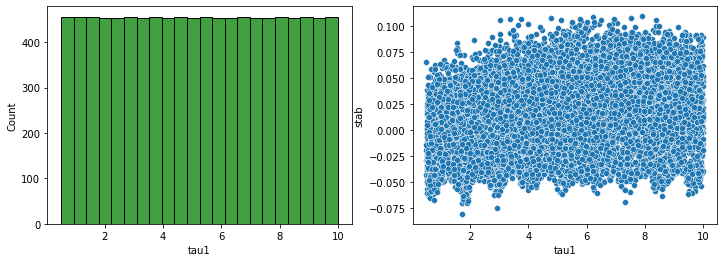

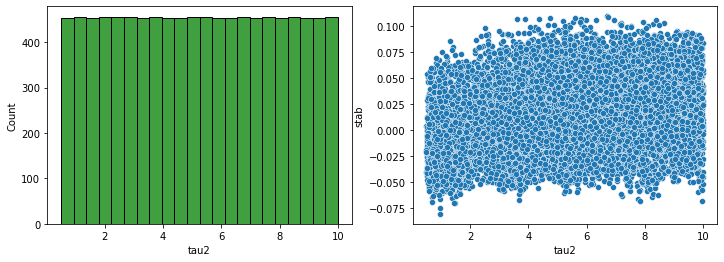

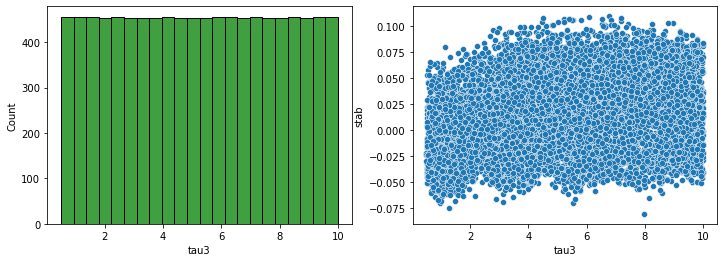

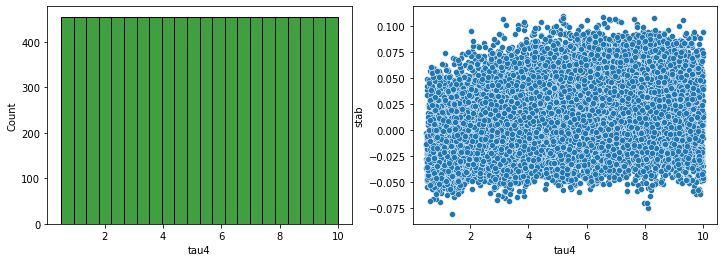

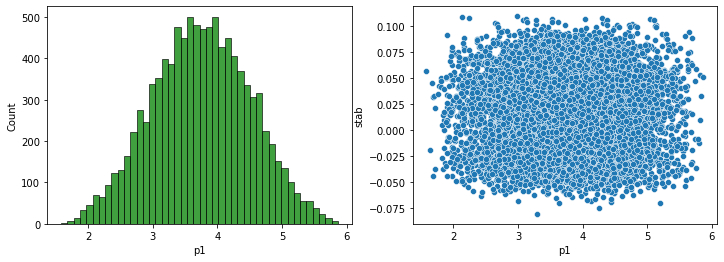

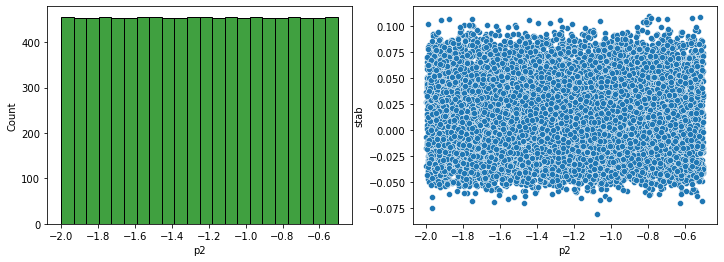

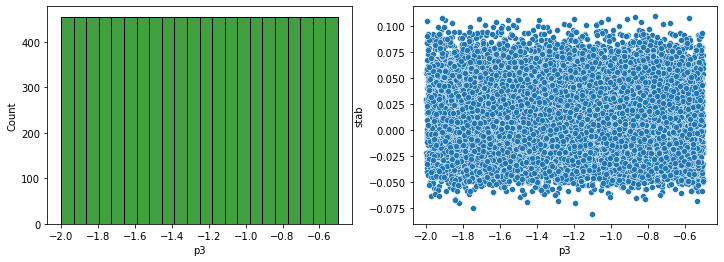

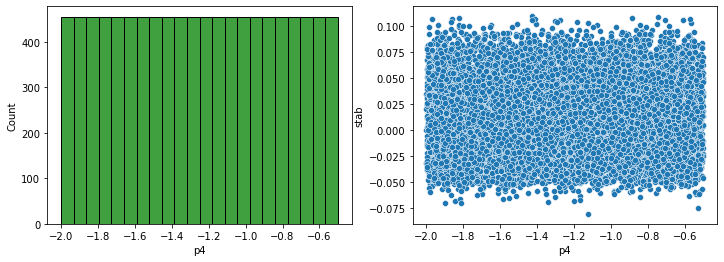

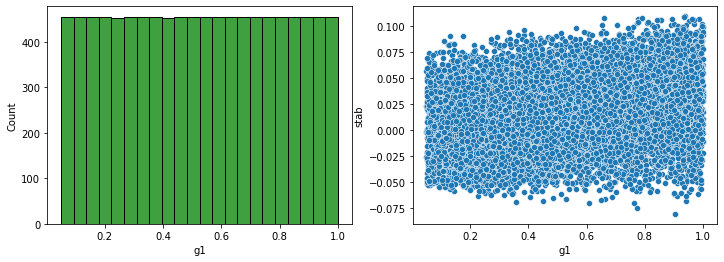

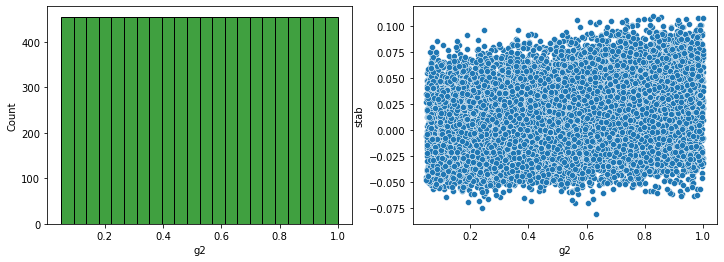

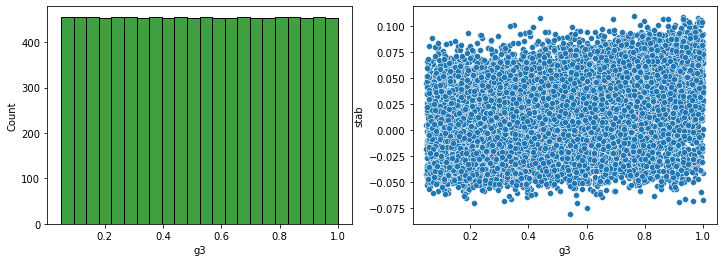

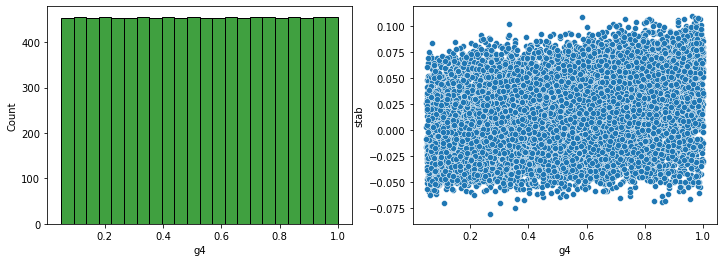

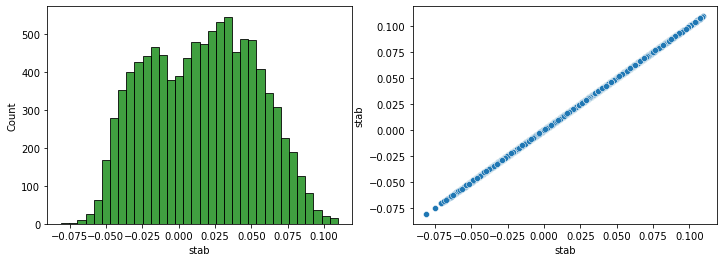

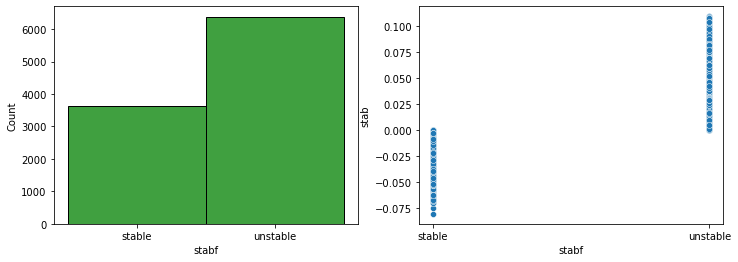

In [10]:
for column in df:
    plot_fig, plot_axes = plt.subplots(1, 2, figsize = (12, 4))
    chart_1 = sns.histplot(x=df[column], ax = plot_axes[0], color='g')
    
    chart_2 = sns.scatterplot(x = column, y = 'stab', data = df, ax = plot_axes[1])

    plt.show()
del plot_fig, plot_axes

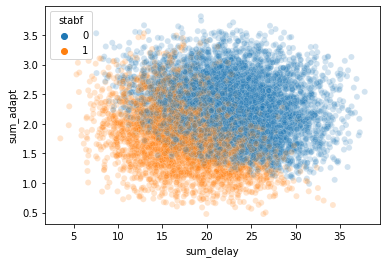

In [11]:
smart_grid = df.assign(stabf = lambda x: x.stabf.replace({"unstable": 0, "stable": 1}))

smart_grid.columns = (smart_grid.columns
                      .str.replace("tau", "delay")
                      .str.replace("p", "power")
                      .str.replace("g", "adapt"))
(smart_grid
 .assign(
     sum_delay = lambda x: x["delay1"] + x["delay2"] + x["delay3"] + x["delay4"],
     sum_adapt = lambda x: x["adapt1"] + x["adapt2"] + x["adapt3"] + x["adapt4"]
 )
 .pipe((sns.scatterplot, "data"), 
       x="sum_delay", y="sum_adapt", hue="stabf", alpha=0.2)
);

Together, very high or very low sums of `delay[x]` and `adapt[x]` values should be indicators of (in)stability. Without further processing, these summarised values would highly correlate with existing features, so I'd rather keep the individual features. In contrast, it might be worth removing all `power[x]` columns if they're unhelpful.

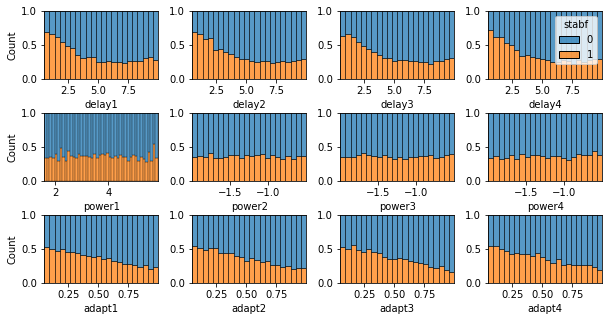

In [12]:
fig, axs = plt.subplots(3, 4, figsize=(10, 5))
plt.subplots_adjust(wspace=0.3, hspace=0.5)

for row_ind, feat_type in enumerate(["delay", "power", "adapt"]):
    for col_ind in range(4):
        show_legend = True if (row_ind == 0) & (col_ind == 3) else False
        sns.histplot(
            smart_grid, x=feat_type + str(col_ind + 1), hue="stabf",
            multiple="fill", legend=show_legend,
            ax=axs[row_ind, col_ind]
        )
        
        if col_ind > 0:
            axs[row_ind, col_ind].set_ylabel("")

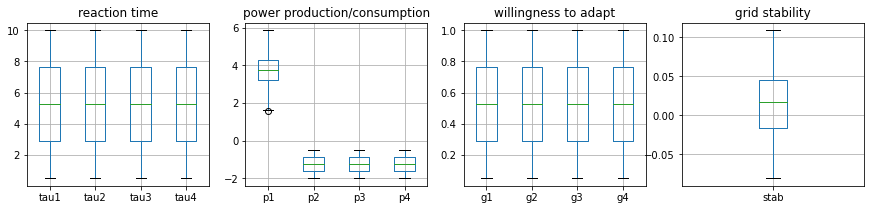

In [13]:
fig, axs = plt.subplots(1, 4, figsize=(15, 3))

for axs_ind, feature_group in enumerate(["tau", "p", "g"]):
    df.boxplot(
        column=[feature_group + str(i + 1) for i in range(4)], 
        ax= axs[axs_ind]
    )
df.boxplot(column="stab", ax= axs[3])

for axs_ind, title in enumerate(["reaction time", "power production/consumption",
                                 "willingness to adapt", "grid stability"]):
    axs[axs_ind].set(title=title);

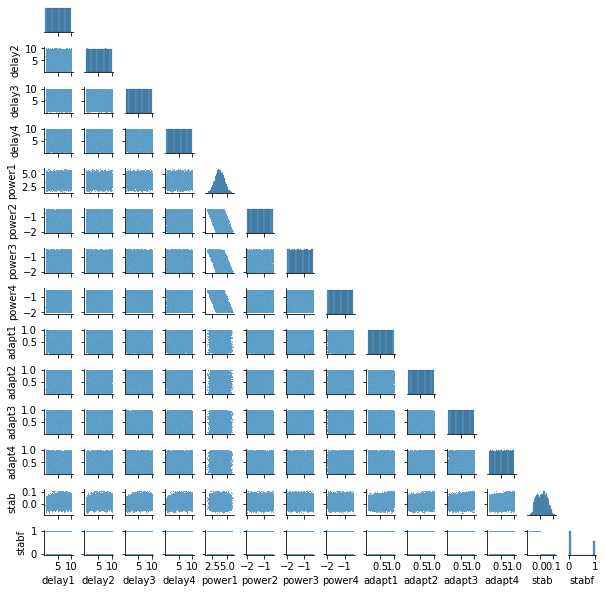

In [14]:
g = sns.PairGrid(smart_grid, diag_sharey=False,
                 corner=True, height=0.6, aspect=1)
g.map_lower(sns.scatterplot, s=1)
g.map_diag(sns.histplot);

## Regression Model 

I first split the data, holding out 20% as the test set and using stratification to keep a consistent class share for the regression task:

In [15]:
 df=df.drop(columns=['stabf'])

In [16]:
df.head()

,tau1,tau2,tau3,tau4,p1,p2,p3,p4,g1,g2,g3,g4,stab
3456,9.577789,1.704913,6.092860,0.633670,5.075044,-1.699826,-1.866091,-1.509127,0.177024,0.611693,0.382866,0.194269,-0.053377
26,5.895693,1.096302,1.311732,8.777868,4.069170,-1.063139,-1.374427,-1.631604,0.867791,0.141839,0.343262,0.711899,0.020088
1398,7.875054,7.078869,1.979034,7.284953,4.780209,-1.293950,-1.844191,-1.642068,0.958949,0.750680,0.809617,0.440623,0.061439
9066,1.333462,8.985584,1.486649,1.052418,3.896600,-0.916748,-1.599593,-1.380259,0.157944,0.266006,0.153400,0.149834,-0.037755
2818,0.786644,7.764954,4.247034,8.264702,2.767843,-0.742338,-0.517574,-1.507931,0.212388,0.325064,0.118108,0.899716,0.015149


In [17]:
DV= 'stab'

In [18]:
IDV=df.columns.tolist()

In [19]:
IDV.remove(DV)

In [20]:
DV

'stab'

In [21]:
IDV

['tau1',
 'tau2',
 'tau3',
 'tau4',
 'p1',
 'p2',
 'p3',
 'p4',
 'g1',
 'g2',
 'g3',
 'g4']

In [22]:
x=df[IDV].values

y=df[DV].values

In [23]:
x_train, x_test, y_train,y_test = train_test_split(x,y, test_size = 0.2, random_state=42)

In [24]:
x_train[:10]

array([[ 2.38606197,  1.06926359,  6.50324193,  4.88296071,  4.98794448,
        -1.22297325, -1.9751428 , -1.78982843,  0.15764282,  0.47801565,
         0.7614003 ,  0.57736291],
       [ 6.85447251,  0.93207705,  9.46063282,  6.05148564,  5.02665584,
        -1.47812943, -1.97275153, -1.57577488,  0.338714  ,  0.85007963,
         0.80804987,  0.40570957],
       [ 4.23167779,  4.02786309,  7.25364356,  9.72873545,  3.95642857,
        -0.79293161, -1.39264783, -1.77084913,  0.32466733,  0.90581347,
         0.93876171,  0.59524677],
       [ 7.61525401,  2.46665049,  9.9596717 ,  7.52561571,  3.97452905,
        -1.32870306, -1.71086955, -0.93495644,  0.37328522,  0.69417031,
         0.81596514,  0.14498437],
       [ 1.38220596,  1.02684951,  8.80290881,  4.52165228,  2.92064585,
        -1.5517773 , -0.58050826, -0.78836029,  0.3992148 ,  0.52555964,
         0.28928821,  0.89747406],
       [ 6.22136055,  8.09703637,  1.78439619,  2.44003217,  2.94800264,
        -0.53505084, -

In [25]:
reg=XGBRegressor(verbosity=0)
print(reg)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)


In [26]:
reg.fit(x_train,y_train)
score=reg.score(x_train,y_train)
print("Training score accuracy:",score)

Training score accuracy: 0.9888774733544361


In [27]:
cvs = cross_val_score(reg, x_train, y_train, cv=10).mean() #mean of cv score
y_pred = cross_val_predict(reg, x_train, y_train, cv=10) #prediction cv
r2 = r2_score(y_train, y_pred)
mse = mean_squared_error(y_train, y_pred)
mae = mean_absolute_error(y_train, y_pred)
rmse = np.sqrt(mse)
result= {'cross_val_score': cvs, 'rmse': rmse, 'mae': mae, 'r2': r2}

In [28]:
pd.DataFrame(result, index=[0])

,cross_val_score,rmse,mae,r2
0,0.930076,0.009738,0.007393,0.930214
